<a href="https://colab.research.google.com/github/Fadoua-ER/BazzArt.-Back-end/blob/main/notebooks/prediction_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Comparative Analysis of ET0 Prediction Models**
This notebook provides a comprehensive comparison of multiple machine learning models for predicting Evapotranspiration (ET0):
1. **LSTM Neural Network (Long short term memory)**
2. **Random Forest**
3. **Decision Tree**
4. **XGBoost**
## Comparison Criteria
- **Accuracy**: RMSE, MAE, R², MAPE
- **Interpretability**: Feature importance, model complexity
- **Training Time**: Computational efficiency
- **Robustness**: Cross-validation performance
- **Seasonal Performance**: Consistency across different seasons


In [1]:
!pip install tensorflow

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import joblib
import os

In [3]:
df = pd.read_csv('dataset.csv', parse_dates=['date'])
df = df.sort_values('date').dropna()

In [5]:
df['month'] = df['date'].dt.month

In [6]:
features = ['tempmin', 'tempmax', 'pressure', 'humidity', 'month']
target = 'ET0'

In [7]:
X = df[features].values
y = df[target].values.reshape(-1, 1)

In [8]:
split_date = '2019-01-01'
train_idx = df['date'] < split_date
test_idx = df['date'] >= split_date

In [9]:
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

In [10]:
#XGBoost Regressor
xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(X_train, y_train.ravel())
pred_xgb = xgb.predict(X_test)

In [11]:
#Random Forest Model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train.ravel())
pred_rf = rf.predict(X_test)

In [12]:
#Decision Tree Model
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train.ravel())
pred_dt = dt.predict(X_test)

In [13]:
#LSTM
def create_lstm_sequences(X, y, window=7):
    Xs, ys = [], []
    for i in range(window, len(X)):
        Xs.append(X[i-window:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

X_lstm, y_lstm = create_lstm_sequences(X, y, window=7)
split_index = int(len(X_lstm) * 0.8)
X_train_lstm, X_test_lstm = X_lstm[:split_index], X_lstm[split_index:]
y_train_lstm, y_test_lstm = y_lstm[:split_index], y_lstm[split_index:]

model = Sequential()
model.add(LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train_lstm, y_train_lstm, epochs=30, batch_size=64, verbose=1)

pred_lstm = model.predict(X_test_lstm).flatten()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.2775
Epoch 2/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7444
Epoch 3/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5652
Epoch 4/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5260
Epoch 5/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4676
Epoch 6/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4444
Epoch 7/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3927
Epoch 8/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3877
Epoch 9/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3867
Epoch 10/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3512
Epoch 11/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3433
Epoch 12/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3467
Epoch 13/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3686
Epoch 14/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3374
Epoch 15/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - l

In [14]:
def evaluate_model(y_true, y_pred, model_name):
    # Core metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # Additional metrics
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mbe = np.mean(y_pred - y_true)
    nrmse = (rmse / np.mean(y_true)) * 100
    numerator = np.sum((y_pred - y_true) ** 2)
    denominator = np.sum((np.abs(y_pred - np.mean(y_true)) + np.abs(y_true - np.mean(y_true))) ** 2)
    willmott_d = 1 - (numerator / denominator)
    nse = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))

    report = f"""
      Performance Report for {model_name}
      =====================================

      Basic Metrics:
      - RMSE: {rmse:.4f}
      - MAE: {mae:.4f}
      - R²: {r2:.4f}

      Additional Metrics:
      - MAPE: {mape:.2f}%
      - MBE: {mbe:.4f}
      - NRMSE: {nrmse:.2f}%
      - Willmott's d: {willmott_d:.4f}
      - Nash-Sutcliffe Efficiency (NSE): {nse:.4f}

      Data Statistics:
      - True Mean: {np.mean(y_true):.4f}
      - Predicted Mean: {np.mean(y_pred):.4f}
      - True Std: {np.std(y_true):.4f}
      - Predicted Std: {np.std(y_pred):.4f}
    """
    return report

In [47]:
print('Models Evaluation')
print('--------------------------------------------')
model_objects = {
    'XGBoost': (xgb, pred_xgb, y_test),
    'Random Forest': (rf, pred_rf, y_test),
    'Decision Tree': (dt, pred_dt, y_test),
    'LSTM': (model, pred_lstm, y_test_lstm.flatten())
}

results = []

for name, (model_obj, preds, true_vals) in model_objects.items():
    rmse = np.sqrt(mean_squared_error(true_vals, preds))
    mae = mean_absolute_error(true_vals, preds)
    r2 = r2_score(true_vals, preds)
    evaluation_report = evaluate_model(true_vals, preds, name)
    print(evaluation_report)
    results.append((name, rmse, mae, r2))

results_df = pd.DataFrame(results, columns=['Model', 'RMSE', 'MAE', 'R²'])
print('--------------------------------------------')
print(results_df)
print('--------------------------------------------')
best_model_name = results_df.sort_values(by="R²", ascending=False).iloc[0]['Model']
best_model_obj = model_objects[best_model_name][0]
print(f"Best model : {best_model_name}")

Models Evaluation
--------------------------------------------

      Performance Report for XGBoost

      Basic Metrics:
      - RMSE: 0.3501
      - MAE: 0.2637
      - R²: 0.9469

      Additional Metrics:
      - MAPE: 63.70%
      - MBE: -0.0154
      - NRMSE: 10.02%
      - Willmott's d: 0.4288
      - Nash-Sutcliffe Efficiency (NSE): -2134.0851

      Data Statistics:
      - True Mean: 3.4935
      - Predicted Mean: 3.4781
      - True Std: 1.5199
      - Predicted Std: 1.4784
    

      Performance Report for Random Forest

      Basic Metrics:
      - RMSE: 0.3375
      - MAE: 0.2515
      - R²: 0.9507

      Additional Metrics:
      - MAPE: 63.49%
      - MBE: -0.0169
      - NRMSE: 9.66%
      - Willmott's d: 0.4284
      - Nash-Sutcliffe Efficiency (NSE): -2117.7054

      Data Statistics:
      - True Mean: 3.4935
      - Predicted Mean: 3.4766
      - True Std: 1.5199
      - Predicted Std: 1.4667
    

      Performance Report for Decision Tree

      Basic Metrics:


In [23]:
train_df = df[train_idx].copy()
test_df = df[test_idx].copy()
train_df.to_csv("training_data.csv", index=False)
print('Saved training_data.csv')
test_df.to_csv("testing_data.csv", index=False)
print('Saved testing_data.csv')

Saved training_data.csv
Saved testing_data.csv


Visuaization Models Metrics
----------------------------------------------------------------------------------------


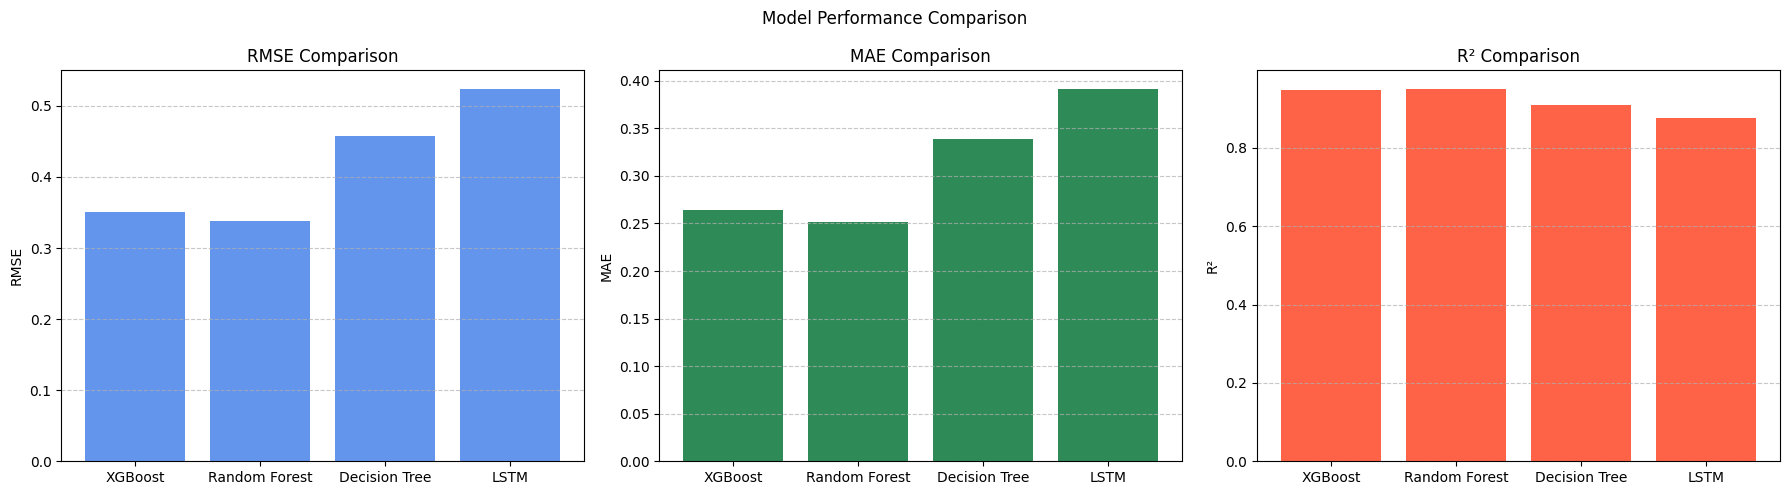

In [24]:
print('Visuaization Models Metrics')
print('----------------------------------------------------------------------------------------')
metrics = ['RMSE', 'MAE', 'R²']
colors = ['cornflowerblue', 'seagreen', 'tomato']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, metric in enumerate(metrics):
    axes[i].bar(results_df['Model'], results_df[metric], color=colors[i])
    axes[i].set_title(f'{metric} Comparison')
    axes[i].set_ylabel(metric)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)
plt.suptitle("Model Performance Comparison")
plt.tight_layout()
plt.show()

Predictions visualization 
----------------------------------------------------------------------------------------
Prediction data saved !
Predicted Vs Actual - XGBoost


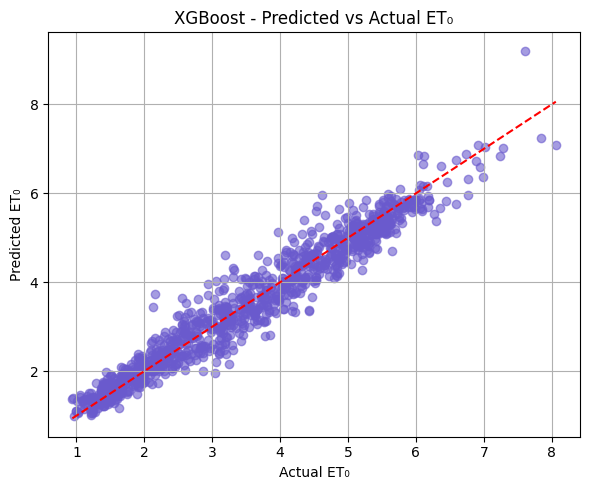

Prediction data saved !
Predicted Vs Actual - Random Forest


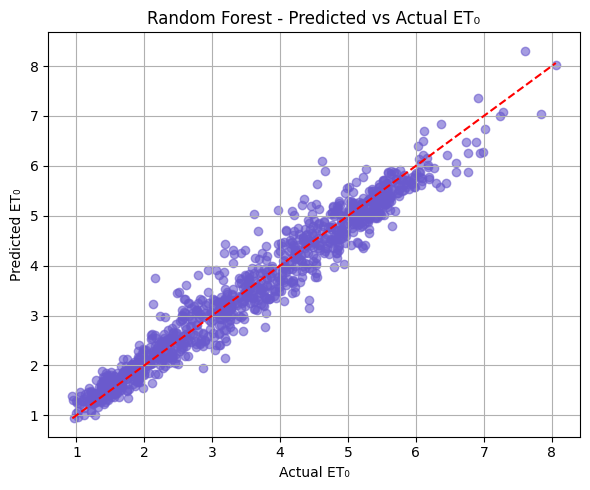

Prediction data saved !
Predicted Vs Actual - Decision Tree


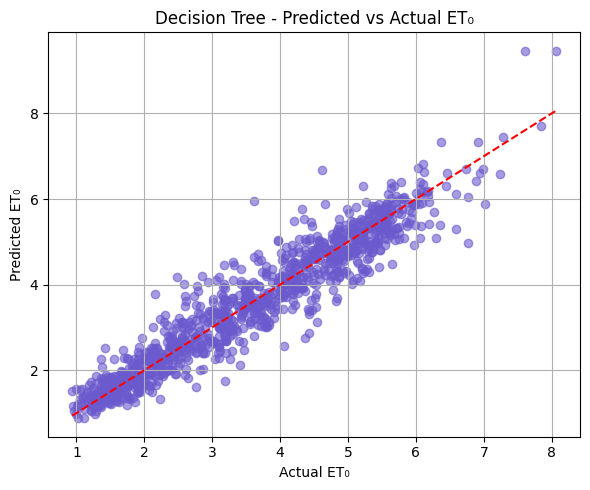

Prediction data saved !
Predicted Vs Actual - LSTM


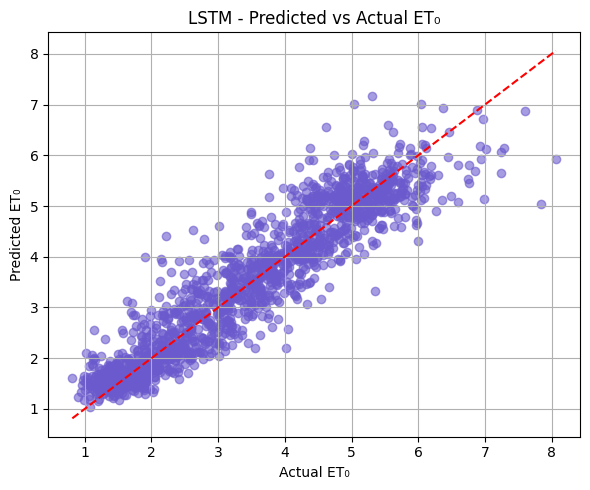

In [34]:
print('Predictions visualization ')
print('----------------------------------------------------------------------------------------')
for name, (model_obj, preds, true_vals) in model_objects.items():
    if name == "LSTM":
        features_data = X_test_lstm[:, -1, :]
    else:
        features_data = X_test

    df_preds = pd.DataFrame(features_data, columns=features)
    df_preds['Actual_ET0'] = true_vals
    df_preds['Predicted_ET0'] = preds
    df_preds.to_csv(f"predicted_data_{name.replace(' ', '_').lower()}.csv", index=False)
    print('Prediction data saved !')
    print('Predicted Vs Actual - '+ str(name))
    plt.figure(figsize=(6, 5))
    plt.scatter(true_vals, preds, alpha=0.6, color='slateblue')
    plt.plot([min(true_vals), max(true_vals)], [min(true_vals), max(true_vals)], 'r--')
    plt.xlabel("Actual ET₀")
    plt.ylabel("Predicted ET₀")
    plt.title(f"{name} - Predicted vs Actual ET₀")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Time series visualization
----------------------------------------------------------------------------------------


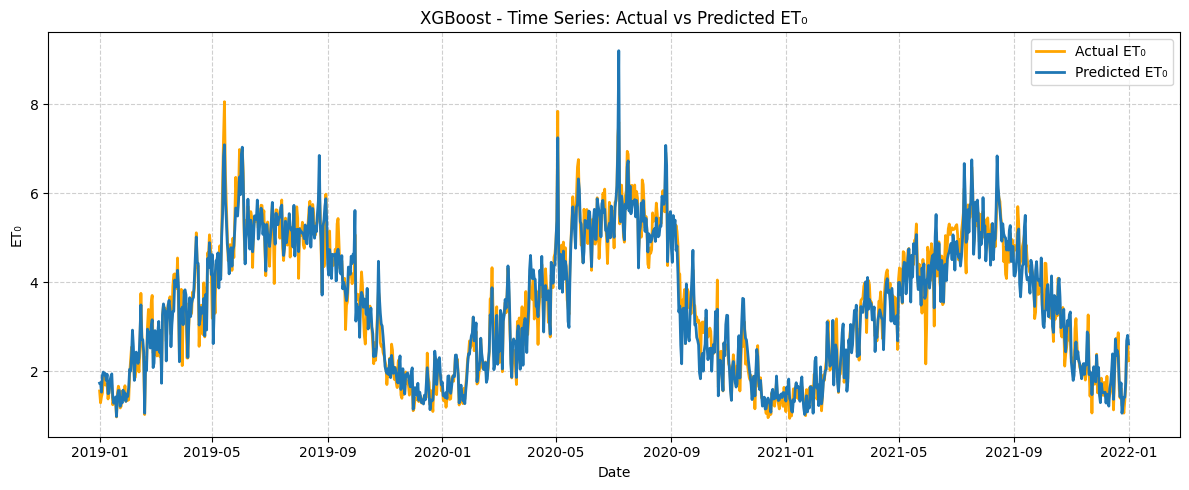

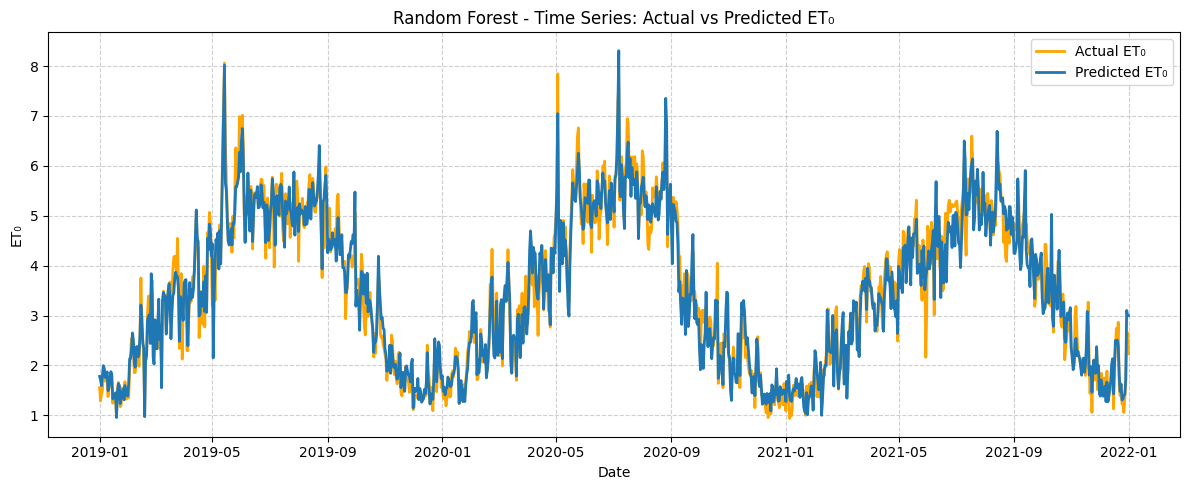

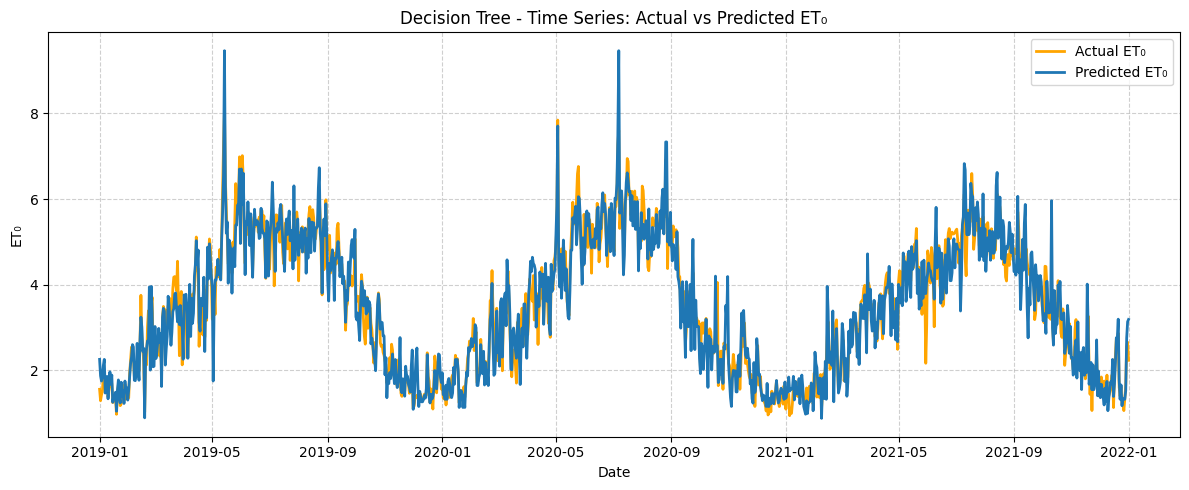

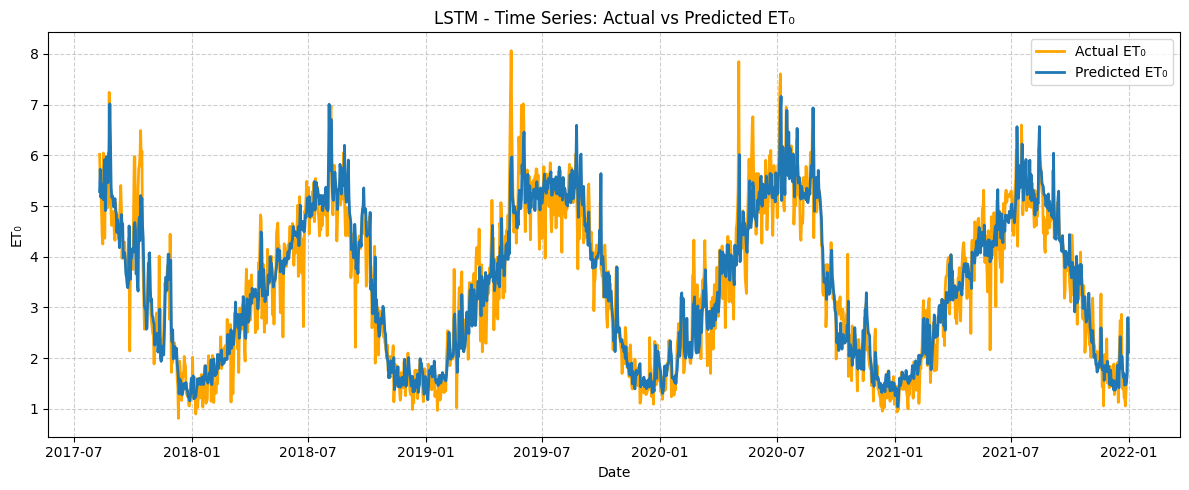

In [35]:
print('Time series visualization')
print('----------------------------------------------------------------------------------------')
for name, (model_obj, preds, true_vals) in model_objects.items():
    if name == "LSTM":
        time_index = df.iloc[-len(y_test_lstm):]['date'].reset_index(drop=True)
    else:
        time_index = df[test_idx]['date'].reset_index(drop=True)

    plt.figure(figsize=(12, 5))
    plt.plot(time_index, true_vals, label="Actual ET₀", color='orange', linewidth=2)
    plt.plot(time_index, preds, label="Predicted ET₀", linewidth=2)
    plt.title(f"{name} - Time Series: Actual vs Predicted ET₀")
    plt.xlabel("Date")
    plt.ylabel("ET₀")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

In [36]:
print('Model Saving')
print('----------------------------------------------------------------------------------------')
if best_model_name == 'LSTM':
    best_model_obj.save('model_lstm.h5')
    print("LSTM model saved as model_lstm.h5")
else:
    best_model_data = {
        'model': best_model_obj,
        'feature_names': features,
        'model_name': best_model_name
    }
    joblib.dump(best_model_data, 'model.pkl')
    print(f"{best_model_name} model saved as model.pkl")

Model Saving
----------------------------------------------------------------------------------------
Random Forest model saved as model.pkl
